# A/B Test: Impact of a New Payment Funnel on Purchase Conversion

- **Author**: Ekaterina Kemenova
- **Date**: 04.01.2026

## 0.1 Project goals and objectives

**Goal:**
Analyze the results of an A/B experiment conducted by a large e-commerce platform to evaluate the impact of a redesigned payment funnel on purchase conversion.

**Context:**
The platform recently ran a controlled A/B test to assess a new payment funnel designed to reduce friction during checkout and increase the probability of purchase. The test has been completed, and the business requires a data-driven evaluation of both the conversion impact and the methodological correctness of the experiment.

**Key objectives:**
- Load and explore the structure of datasets;
- Perform data preprocessing (data type corrections, missing values, duplicates);
- Conduct exploratory data analysis to compare conversion rates across test groups and analyze cumulative purchase dynamics;
- Validate A/B test correctness (group assignment, sample balance, data integrity);
- Apply appropriate statistical tests to assess the effect of the new payment funnel on conversion;
- Provide data-driven recommendations based on the observed effects.
---

## 0.2 Data description

The analysis is based on four datasets:

- **new_users_test_2025.csv** — all users who registered between *2025-06-01* and *2025-06-14*.
- **sessions_test_2025.csv** — all sessions of new users between *2025-06-01* and *2025-06-21*.
- **purchases_test_2025.csv** — all purchases made by new users between *2025-06-01* and *2025-06-21*.
- **participants_test_2025.csv** — A/B test participant list, including the assigned group and test name.

These datasets are linked by `user_id` and represent the full user funnel during the experiment.

**new_users_test_2025.csv**
- `user_id` — unique user identifier  
- `first_date` — registration date  
- `region` — user region  
- `device` — device used for registration  

**sessions_test_2025.csv**
- `user_id` — unique user identifier  
- `session_start` — session start timestamp  
- `session_duration` — session duration (minutes)  

**purchases_test_2025.csv**
- `user_id` — unique user identifier  
- `event_dt` — purchase timestamp  
- `revenue` — purchase revenue (USD)  

**participants_test_2025.csv**
- `user_id` — unique user identifier  
- `group` — A/B test group (control vs. test)  
- `ab_test` — A/B test name  

## 0.3 Project structure
1. [Data loading and overview](#data-loading-and-overview)  
2. [Data preprocessing](#data-preprocessing)  
3. [A/B test setup validation](#ab-test-setup-validation)  
4. [Exploratory data analysis](#exploratory-data-analysis)
5. [A/B test results analysis](#ab-test-results-analysis) 
6. [Final conclusions and recommendations](#final-conclusions-and-recommendations)
---

<a id='data-loading-and-overview'></a>
## 1. Data loading and overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df_new_users = pd.read_csv('new_users_test_2025.csv')
df_sessions = pd.read_csv('sessions_test_2025.csv')
df_purchases = pd.read_csv('purchases_test_2025.csv')
df_participants = pd.read_csv('participants_test_2025.csv')

In [3]:
for df in [df_new_users, df_sessions, df_purchases, df_participants]:
    print('General dataset information:')
    df.info()
    
    print('\nFirst 5 rows of the dataset:')
    display(df.head())

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131486 entries, 0 to 131485
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     131486 non-null  object
 1   first_date  131486 non-null  object
 2   region      131486 non-null  object
 3   device      131486 non-null  object
dtypes: object(4)
memory usage: 4.0+ MB

First 5 rows of the dataset:


,user_id,first_date,region,device
0,D72A72121175D8BE,2025-06-01,South Asia,iPhone
1,F1C668619DFE6E65,2025-06-01,Southeast Asia,iPhone
2,2E1BF1D4C37EA01F,2025-06-01,Central Asia,Mac
3,50734A22C0C63768,2025-06-01,Central Asia,Android
4,E1BDDCE0DAFA2679,2025-06-01,Southeast Asia,iPhone


General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491443 entries, 0 to 491442
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           491443 non-null  object 
 1   session_start     491443 non-null  object 
 2   session_duration  491443 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.2+ MB

First 5 rows of the dataset:


,user_id,session_start,session_duration
0,D72A72121175D8BE,2025-06-01 05:51:20,1.0
1,F1C668619DFE6E65,2025-06-01 15:28:14,5.0
2,2E1BF1D4C37EA01F,2025-06-01 16:19:36,3.0
3,50734A22C0C63768,2025-06-01 21:06:51,1.0
4,E1BDDCE0DAFA2679,2025-06-01 10:03:00,2.0


General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149152 entries, 0 to 149151
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   149152 non-null  object 
 1   event_dt  149152 non-null  object 
 2   revenue   149152 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.4+ MB

First 5 rows of the dataset:


,user_id,event_dt,revenue
0,50734A22C0C63768,2025-06-01 21:06:51,4.99
1,0FC21E6F8FAA8DEC,2025-06-01 06:36:08,4.99
2,9CD9F34546DF254C,2025-06-01 14:40:29,99.99
3,1FD7660FDF94CA1F,2025-06-01 04:53:00,4.99
4,E6AF85675078215D,2025-06-01 11:40:09,4.99


General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3291 entries, 0 to 3290
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3291 non-null   object
 1   group    3291 non-null   object
 2   ab_test  3291 non-null   object
dtypes: object(3)
memory usage: 77.3+ KB

First 5 rows of the dataset:


,user_id,group,ab_test
0,6A8825D752FCFFB6,A,new_payment_funnel_test_summer_2025
1,0B75608CBBA59791,B,new_payment_funnel_test_summer_2025
2,6B9D2F7685B83C73,A,new_payment_funnel_test_summer_2025
3,6435D4C2E66A7F75,B,new_payment_funnel_test_summer_2025
4,4F815438BBD2BB7E,A,new_payment_funnel_test_summer_2025


The data in all datasets matches the descriptions.

**`new_users_test_2025.csv`:**
- 4 columns and 131,486 rows;
- The `first_date` field must be converted from `object` to `datetime`;
- No missing values detected.

**`sessions_test_2025.csv`:**
- 3 columns and 491,443 rows;
- The `session_start` field must be converted to `datetime`, and `session_duration` should be stored as an integer;
- No missing values detected.

**`purchases_test_2025.csv`:**
- 3 columns and 149,152 rows;
- The `event_dt` field must be converted to `datetime`;
- No missing values detected.

**`participants_test_2025.csv`:**
- 3 columns and 3,291 rows;
- All columns have appropriate data types;
- No missing values detected.

---
<a id='data-preprocessing'></a>
## 2. Data preprocessing

### 2.1 Data type conversion and quality checks

We convert the data to the appropriate data types:

In [4]:
df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'])
df_sessions['session_start'] = pd.to_datetime(df_sessions['session_start'])
df_sessions['session_duration'] = df_sessions['session_duration'].astype('int64')
df_purchases['event_dt'] = pd.to_datetime(df_purchases['event_dt'])

In [5]:
for df in [df_new_users, df_sessions, df_purchases]:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131486 entries, 0 to 131485
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     131486 non-null  object        
 1   first_date  131486 non-null  datetime64[ns]
 2   region      131486 non-null  object        
 3   device      131486 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491443 entries, 0 to 491442
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           491443 non-null  object        
 1   session_start     491443 non-null  datetime64[ns]
 2   session_duration  491443 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 11.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149152 entries, 0 to 149151
Data

In [6]:
 for df in [df_new_users, df_sessions, df_purchases, df_participants]:
    for column in df.columns:
        if df[column].dtype == 'object' and column != 'user_id':
            print (f'\nUnique values in the {column} column: {df[column].unique()}')


Unique values in the region column: ['South Asia' 'Southeast Asia' 'Central Asia' 'East Asia']

Unique values in the device column: ['iPhone' 'Mac' 'Android' 'PC']

Unique values in the group column: ['A' 'B']

Unique values in the ab_test column: ['new_payment_funnel_test_summer_2025' 'new_login_screen_apac']


The categorical variables contain valid values.  

Since the `new_login_screen_apac` experiment is not relevant to this analysis, it is filtered out from the dataset:

In [7]:
df_participants = df_participants[df_participants['ab_test'] == 'new_payment_funnel_test_summer_2025']

In [8]:
 for df in [df_new_users, df_sessions, df_purchases, df_participants]:
    for column in df.columns:
        if df[column].dtype == 'int64' or df[column].dtype == 'float64':
            print(f'\nDescriptive statistics for the numerical {column} column:\n{df[column].describe()}')


Descriptive statistics for the numerical session_duration column:
count    491443.000000
mean          2.013973
std           1.426262
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          12.000000
Name: session_duration, dtype: float64

Descriptive statistics for the numerical revenue column:
count    149152.000000
mean         23.983342
std          72.260378
min           4.990000
25%           4.990000
50%           4.990000
75%           9.990000
max         499.990000
Name: revenue, dtype: float64


The `revenue` column contains outliers: the mean differs substantially from the median, and the standard deviation is high. This should be taken into account when selecting an appropriate statistical test.

### 2.2 Missing values analysis

In [9]:
 for df in [df_new_users, df_sessions, df_purchases, df_participants]:
    missing_df = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_share': df.isna().mean()}).sort_values(by='missing_count', ascending=False)
    print ('\nMissing values summary:')
    display(missing_df)


Missing values summary:


,missing_count,missing_share
user_id,0,0.0
first_date,0,0.0
region,0,0.0
device,0,0.0



Missing values summary:


,missing_count,missing_share
user_id,0,0.0
session_start,0,0.0
session_duration,0,0.0



Missing values summary:


,missing_count,missing_share
user_id,0,0.0
event_dt,0,0.0
revenue,0,0.0



Missing values summary:


,missing_count,missing_share
user_id,0,0.0
group,0,0.0
ab_test,0,0.0


No missing values were detected.

### 2.3 Detection of explicit and implicit duplicates

In [10]:
for df in [df_new_users, df_sessions, df_purchases, df_participants]:
    print (f'Total number of duplicate records: {df.duplicated().sum()}')
    print (f'Share of duplicate records: {(df.duplicated().sum()/ df.shape[0])}')

Total number of duplicate records: 0
Share of duplicate records: 0.0
Total number of duplicate records: 0
Share of duplicate records: 0.0
Total number of duplicate records: 0
Share of duplicate records: 0.0
Total number of duplicate records: 0
Share of duplicate records: 0.0


We verify the uniqueness of user identifiers:

In [11]:
for df in [df_new_users, df_participants]:
    print(df.duplicated(subset='user_id').sum())

0
0


No explicit or implicit duplicates were detected.

---
<a id='ab-test-setup-validation'></a>
## 3. A/B test setup validation

### 3.1 Defining the null and alternative hypotheses

As the primary metric, we use **purchase conversion**.

- **H0**: The purchase conversion rate does not change after the introduction of the new payment funnel.
- **H1**: The purchase conversion rate changes after the introduction of the new payment funnel.

### 3.2 Validation of A/B test correctness

To analyze the A/B test data, we merge the relevant datasets:

In [12]:
df = df_participants.merge(df_new_users, how='left', on='user_id')
df = df.merge(df_purchases, how='left', on='user_id')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4890 entries, 0 to 4889
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     4890 non-null   object        
 1   group       4890 non-null   object        
 2   ab_test     4890 non-null   object        
 3   first_date  4890 non-null   datetime64[ns]
 4   region      4890 non-null   object        
 5   device      4890 non-null   object        
 6   event_dt    2566 non-null   datetime64[ns]
 7   revenue     2566 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 343.8+ KB


We calculate the number of unique users in each experimental group and the percentage difference between them:

In [14]:
group_agg = df.groupby('group')['user_id'].nunique().reset_index()
group_agg

,group,user_id
0,A,1598
1,B,1468


In [15]:
group_agg_A = group_agg[group_agg['group'] == 'A']['user_id'].iloc[0]
group_agg_B = group_agg[group_agg['group'] == 'B']['user_id'].iloc[0]

percent_difference = 100 * (group_agg_A - group_agg_B) / group_agg_A
percent_difference

8.135168961201503

The sizes of the control and test groups differ by approximately 8%.

We verify that the groups are independent and that no users appear in both groups A and B:

In [16]:
df.groupby('user_id')['group'].nunique().reset_index().sort_values(by='group', ascending=False)

,user_id,group
0,002057F7D795A6D5,1
2047,AD8F832B1A4C76DD,1
2038,AD15DE189CD5F61A,1
2039,AD1D0074F91AC587,1
2040,AD1E9253F7D06A28,1
...,...,...
1024,590B7B27E78FC2A2,1
1025,592D185DE0C113D5,1
1026,5930DF8E6DFE7577,1
1027,5936628883D6B68F,1


No user overlap between groups A and B was detected, confirming group independence.

We verify that users are evenly distributed across categorical variables, including device types and regions:

In [17]:
df.groupby(['group','device'])['user_id'].nunique()

group  device 
A      Android    717
       Mac        135
       PC         423
       iPhone     323
B      Android    642
       Mac        164
       PC         371
       iPhone     291
Name: user_id, dtype: int64

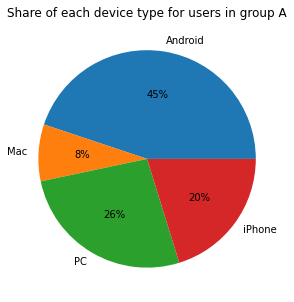

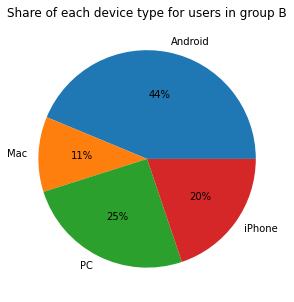

In [18]:
plt.figure (figsize = (10,5))

df[df['group'] == 'A'].groupby('device')['user_id'].nunique().plot(
    kind='pie',
    title='Share of each device type for users in group A',
    autopct='%.0f%%',
    ylabel=''
)

plt.show()

plt.figure (figsize = (10,5))

df[df['group'] == 'B'].groupby('device')['user_id'].nunique().plot(
    kind='pie',
    title='Share of each device type for users in group B',
    autopct='%.0f%%',
    ylabel=''
)

plt.show()

In [19]:
df.groupby(['group','region'])['user_id'].nunique()

group  region        
A      Central Asia        28
       East Asia           25
       South Asia          12
       Southeast Asia    1533
B      Central Asia        19
       East Asia           17
       South Asia          14
       Southeast Asia    1418
Name: user_id, dtype: int64

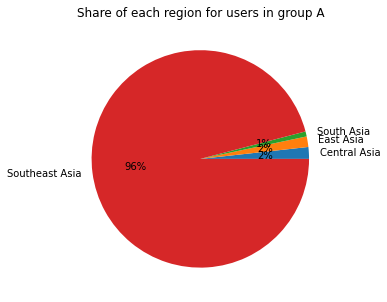

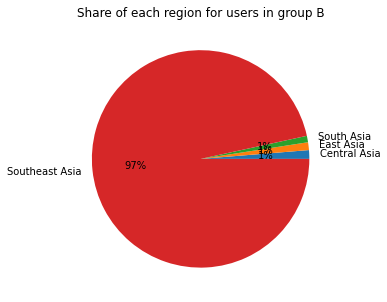

In [20]:
plt.figure (figsize = (10,5))

df[df['group'] == 'A'].groupby('region')['user_id'].nunique().plot(
    kind='pie',
    title='Share of each region for users in group A',
    autopct='%.0f%%',
    ylabel=''
)

plt.show()

plt.figure (figsize = (10,5))

df[df['group'] == 'B'].groupby('region')['user_id'].nunique().plot(
    kind='pie',
    title='Share of each region for users in group B',
    autopct='%.0f%%',
    ylabel=''
)

plt.show()

User distributions across categorical variables (device type and region) are balanced between the two groups.

Overall, the A/B test was conducted correctly. 

<a id='exploratory-data-analysis'></a>
## 4. Exploratory data analysis

### 4.1 Exploratory analysis of metrics

We calculate the primary metric (purchase conversion rate) and analyze its cumulative dynamics.

In [21]:
def categorize_buyers (row):
    if pd.notna(row['event_dt']):
        return 1 
    else:
        return 0 
    
df['is_buyer'] = df.apply(categorize_buyers, axis=1)

In [22]:
dates = pd.date_range(start=df['first_date'].min(), end=pd.to_datetime('2025-06-21'))

In [23]:
result = []

for date in dates:
    for group in ['A', 'B']:
        users_to_date = df[(df['group'] == group) & (df['first_date'] <= date)]

        total_users = users_to_date['user_id'].nunique()

        buyers_to_date = users_to_date[(users_to_date['is_buyer'] == 1) & (users_to_date['event_dt'] <= date)]['user_id'].nunique()

        conversion = buyers_to_date / total_users if total_users > 0 else 0

        result.append({
            'date': date,
            'group': group,
            'total_users': total_users,
            'buyers': buyers_to_date,
            'conversion_cum': conversion
        })

In [24]:
cum_conversion = pd.DataFrame(result)
cum_conversion.head()

,date,group,total_users,buyers,conversion_cum
0,2025-06-01,A,166,0,0.000000
1,2025-06-01,B,161,0,0.000000
2,2025-06-02,A,273,44,0.161172
3,2025-06-02,B,254,48,0.188976
4,2025-06-03,A,355,68,0.191549


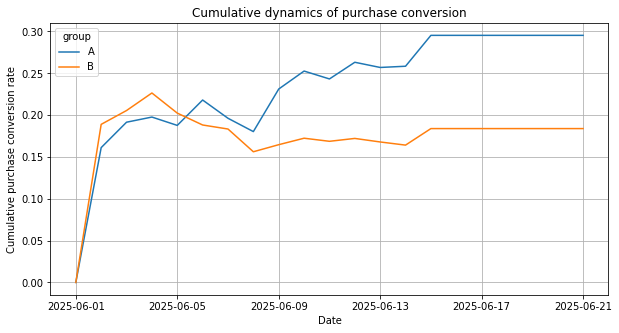

In [25]:
plt.figure(figsize=(10, 5))

sns.lineplot(
    data=cum_conversion,
    x='date',
    y='conversion_cum',
    hue='group'
)

plt.title('Cumulative dynamics of purchase conversion')
plt.xlabel('Date')
plt.ylabel('Cumulative purchase conversion rate')
plt.grid()
plt.show()

The cumulative purchase conversion in the control group (A) is higher than in the test group (B). After the initial data accumulation period, the curves stabilize and do not intersect, indicating a persistent difference between the groups. This difference will be evaluated using a statistical test later.

Next, we analyze proxy metrics:

In [26]:
new_users_daily = df.groupby(['first_date', 'group'])['user_id'].nunique().reset_index().sort_values(by='first_date')

new_users_daily['users_cum'] = new_users_daily.groupby('group')['user_id'].cumsum()

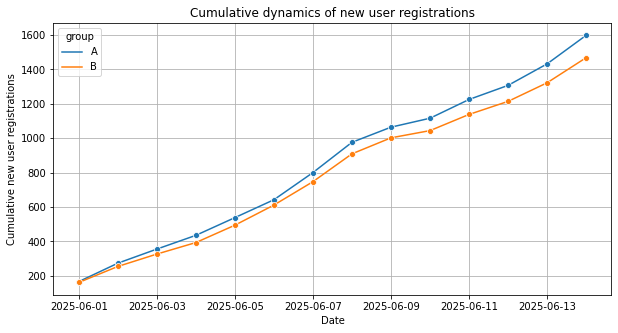

In [27]:
plt.figure(figsize=(10,5))
sns.lineplot(data=new_users_daily, x='first_date', y='users_cum', hue='group', marker='o')
plt.title('Cumulative dynamics of new user registrations')
plt.xlabel('Date')
plt.ylabel('Cumulative new user registrations')
plt.grid()
plt.show()

In [28]:
df_sessions['session_date'] = df_sessions['session_start'].dt.floor('D')

df_sessions_with_group = df_sessions.merge(df_participants[['user_id', 'group']], on='user_id', how='inner')

In [29]:
sessions_daily = df_sessions_with_group.groupby(['session_date', 'group'])['user_id'].size().reset_index().sort_values(by='session_date')

sessions_daily['sessions_cum'] = sessions_daily.groupby('group')['user_id'].cumsum()

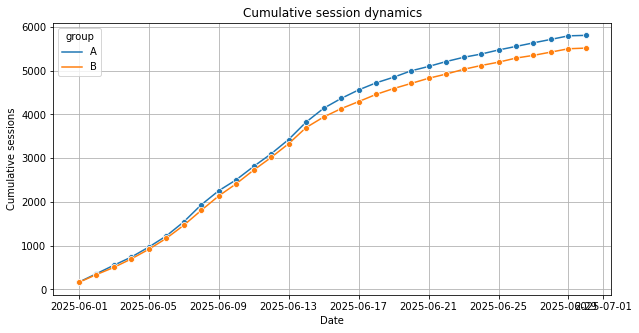

In [30]:
plt.figure(figsize=(10,5))
sns.lineplot(data=sessions_daily, x='session_date', y='sessions_cum', hue='group', marker='o')
plt.title('Cumulative session dynamics')
plt.xlabel('Date')
plt.ylabel('Cumulative sessions')
plt.grid()
plt.show()

In [31]:
df_purchases['purchase_date'] = df_purchases['event_dt'].dt.floor('D')

df_purchases_with_group = df_purchases.merge(df_participants[['user_id', 'group']], on='user_id', how='inner')

In [32]:
purchases_daily = df_purchases_with_group.groupby(['purchase_date', 'group'])['user_id'].size().reset_index().sort_values(by='purchase_date')

purchases_daily['purchases_cum'] = purchases_daily.groupby('group')['user_id'].cumsum()

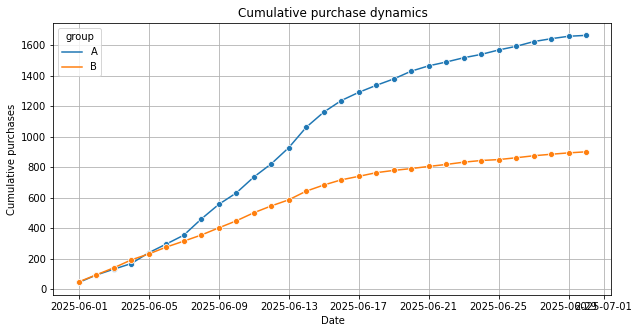

In [33]:
plt.figure(figsize=(10,5))
sns.lineplot(data=purchases_daily, x='purchase_date', y='purchases_cum', hue='group', marker='o')
plt.title('Cumulative purchase dynamics')
plt.xlabel('Date')
plt.ylabel('Cumulative purchases')
plt.grid()
plt.show()

While cumulative new users and sessions are well balanced between groups (with a small lead for group A), cumulative purchases increase noticeably faster in the control group A. The difference builds up gradually and remains stable through the end of the test, indicating a consistent effect of the tested changes.

<a id='ab-test-results-analysis'></a>
## 5. A/B test results analysis

Calculating the primary metric for groups A and B, as well as the difference between them:

In [34]:
buyers = df_purchases_with_group.groupby('group')['user_id'].nunique()

total_users = df.groupby('group')['user_id'].nunique()

conversion = (buyers / total_users).reset_index(name='conversion')

print('Purchase conversion rate by group (buyers / registered users):')
display(conversion)

percent_diff = 100 * (conversion[conversion['group'] == 'B']['conversion'].iloc[0] - conversion[conversion['group'] == 'A']['conversion'].iloc[0]) / conversion[conversion['group'] == 'A']['conversion'].iloc[0]

print(f'Relative difference (B vs. A): {percent_diff:.2f}%')

Purchase conversion rate by group (buyers / registered users):


,group,conversion
0,A,0.295369
1,B,0.183924


Relative difference (B vs. A): -37.73%


The purchase conversion rate in the control group A (29.54%) is noticeably higher than in the test group B (18.39%). This corresponds to an absolute difference of 11.14 percentage points and a relative decrease of 37.7% in the test group. 

The next step is to verify whether this difference is statistically significant.

We use a two-proportion Z-test, as the target metric is a proportion (purchase conversion rate):

In [35]:
buyers_A = buyers['A']
buyers_B = buyers['B']
total_users_A = total_users['A']
total_users_B = total_users['B']

alpha = 0.05

z_score, p_value = proportions_ztest([buyers_A, buyers_B],[total_users_A, total_users_B], alternative='two-sided')

print('P-value:', p_value)

if (p_value < alpha):
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

P-value: 6.133875531186003e-13
Reject the null hypothesis


The null hypothesis is rejected: the change in purchase conversion is statistically significant.

---
<a id='final-conclusions-and-recommendations'></a>
## 5. Final conclusions and recommendations

The A/B test was conducted correctly: the control and test groups are comparable in terms of unique user counts, the samples are independent, and user distributions across categorical variables are balanced.

The primary metric of the experiment was purchase conversion. The following hypotheses were tested:

- **H0:** The purchase conversion rate does not change after the introduction of the new payment funnel.  
- **H1:** The purchase conversion rate changes after the introduction of the new payment funnel.

The test results show a statistically significant change in the primary metric, which allows us to reject the null hypothesis. However, the observed effect is negative: the purchase conversion rate in the test group B is approximately **37.7% lower** in relative terms compared to the control group A.

We conclude that the introduction of the new payment funnel led to a decline in purchase conversion. Therefore, we do not recommend rolling out this change to production and suggest conducting additional diagnostics to understand which steps of the checkout flow may be causing user drop-off.